In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os

In [16]:

def calculate_angle(p1, p2, p3):
    """
    Calculate the angle at p2 formed by the line segments p1-p2 and p3-p2.
    Arguments:
    - p1, p2, p3: Arrays or lists containing the coordinates [x, y, z].
    Returns:
    - Angle in degrees.
    """
    # Create vectors
    v1 = np.array(p1) - np.array(p2)
    v2 = np.array(p3) - np.array(p2)

    # Calculate the dot product and magnitudes
    dot_product = np.dot(v1, v2)
    magnitude_v1 = np.linalg.norm(v1)
    magnitude_v2 = np.linalg.norm(v2)

    # Avoid division by zero
    if magnitude_v1 == 0 or magnitude_v2 == 0:
        return None

    # Calculate the angle in radians
    angle_radians = np.arccos(dot_product / (magnitude_v1 * magnitude_v2))
    # Convert to degrees
    angle_degrees = np.degrees(angle_radians)
    return angle_degrees

# Load the CSV
input_file = "merged_output.csv"  # Replace with your input file
output_file = "output_with_angles.csv"

# Columns for the joints
columns = {
    "LEFT_HIP": ["LEFT_HIP_x", "LEFT_HIP_y", "LEFT_HIP_z"],
    "LEFT_KNEE": ["LEFT_KNEE_x", "LEFT_KNEE_y", "LEFT_KNEE_z"],
    "LEFT_ANKLE": ["LEFT_ANKLE_x", "LEFT_ANKLE_y", "LEFT_ANKLE_z"],
    "RIGHT_HIP": ["RIGHT_HIP_x", "RIGHT_HIP_y", "RIGHT_HIP_z"],
    "RIGHT_KNEE": ["RIGHT_KNEE_x", "RIGHT_KNEE_y", "RIGHT_KNEE_z"],
    "RIGHT_ANKLE": ["RIGHT_ANKLE_x", "RIGHT_ANKLE_y", "RIGHT_ANKLE_z"],
}

# Read the data
df = pd.read_csv(input_file)

# Calculate angles for each frame
angles = []
for _, row in df.iterrows():
    left_knee_angle = calculate_angle(
        row[columns["LEFT_HIP"]], 
        row[columns["LEFT_KNEE"]], 
        row[columns["LEFT_ANKLE"]]
    )
    right_knee_angle = calculate_angle(
        row[columns["RIGHT_HIP"]], 
        row[columns["RIGHT_KNEE"]], 
        row[columns["RIGHT_ANKLE"]]
    )
    angles.append({"LEFT_KNEE_ANGLE": left_knee_angle, "RIGHT_KNEE_ANGLE": right_knee_angle})

# Add angles to the DataFrame
angles_df = pd.DataFrame(angles)
result_df = pd.concat([df, angles_df], axis=1)

# Save to a new CSV
result_df.to_csv(output_file, index=False)
print(f"Processed data saved to {output_file}")


Processed data saved to output_with_angles.csv


In [17]:
movement_data = pd.read_csv("output_with_angles.csv")
movement_data

,frame,LEFT_ANKLE_x,LEFT_EAR_x,LEFT_ELBOW_x,LEFT_EYE_x,LEFT_EYE_INNER_x,LEFT_EYE_OUTER_x,LEFT_FOOT_INDEX_x,LEFT_HEEL_x,LEFT_HIP_x,...,RIGHT_INDEX_z,RIGHT_KNEE_z,RIGHT_PINKY_z,RIGHT_SHOULDER_z,RIGHT_THUMB_z,RIGHT_WRIST_z,annotation,videoid,LEFT_KNEE_ANGLE,RIGHT_KNEE_ANGLE
0,0.000000,0.526178,0.454818,0.579769,0.435435,0.424799,0.445332,0.570951,0.513027,0.484337,...,0.210203,0.493727,0.236498,0.325306,0.253600,0.266685,Still,bapproach1,136.862273,130.945609
1,0.007407,0.525655,0.454755,0.579388,0.435266,0.424666,0.444514,0.567500,0.512050,0.484133,...,0.220754,0.494478,0.247105,0.331144,0.262427,0.275492,Still,bapproach1,134.261522,130.383060
2,0.014815,0.524938,0.453879,0.578138,0.434714,0.423830,0.443160,0.565493,0.510918,0.481966,...,0.220191,0.494378,0.245681,0.328713,0.261951,0.274716,Still,bapproach1,133.427105,130.180025
3,0.022222,0.524238,0.450395,0.576506,0.433364,0.421889,0.441080,0.564397,0.510423,0.479499,...,0.205395,0.496902,0.231729,0.321172,0.248262,0.261434,Still,bapproach1,133.931554,131.060877
4,0.029630,0.523820,0.446120,0.572280,0.429352,0.417237,0.437730,0.564309,0.509886,0.475675,...,0.203967,0.500852,0.229942,0.321479,0.246645,0.259679,Still,bapproach1,134.559533,133.379099
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7582,0.949367,0.655740,0.493633,0.835403,0.442184,0.420509,0.462624,0.764315,0.626971,0.614757,...,0.313152,0.751724,0.338444,0.450269,0.361474,0.374412,stand,sstand2,143.144608,151.472893
7583,0.962025,0.655860,0.492817,0.823598,0.441257,0.419645,0.462477,0.764197,0.625224,0.607706,...,0.347895,0.766156,0.373864,0.482316,0.396372,0.409577,stand,sstand2,145.402732,154.524642
7584,0.974684,0.655866,0.486263,0.813894,0.438623,0.418643,0.460635,0.764177,0.622663,0.600839,...,0.361718,0.745588,0.388165,0.502106,0.410555,0.423952,stand,sstand2,141.881191,150.581242
7585,0.987342,0.656129,0.478312,0.798870,0.435743,0.417290,0.457135,0.764033,0.622570,0.595394,...,0.372646,0.740648,0.398608,0.511323,0.421087,0.434140,stand,sstand2,139.863571,149.718221


C:\Users\57312\AppData\Local\Temp\ipykernel_11512\2253452055.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videoid_data['SHOULDER_DISTANCE_x'] = abs(videoid_data['LEFT_SHOULDER_x'] - videoid_data['RIGHT_SHOULDER_x'])


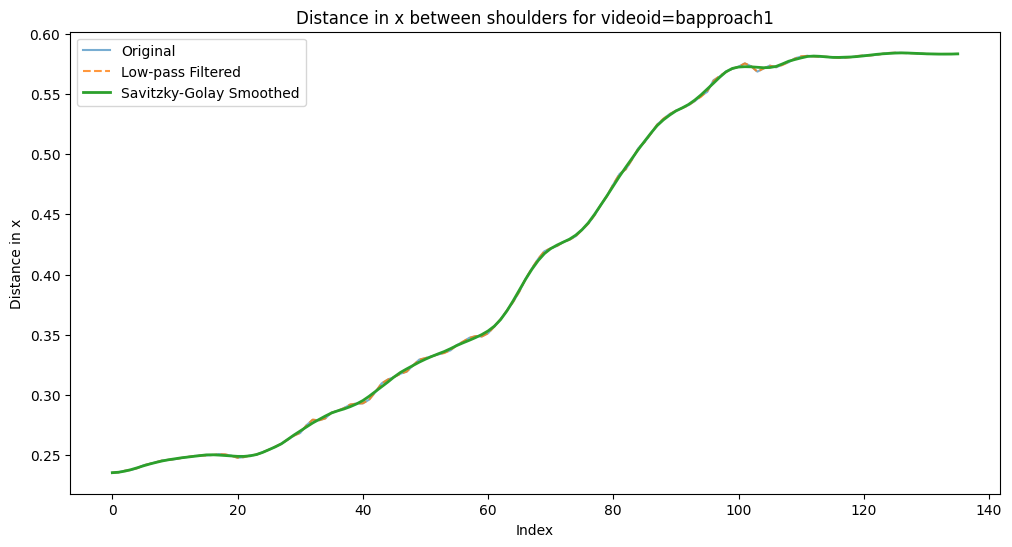

In [68]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, savgol_filter

# Definir el video_id que deseas graficar
specific_video_id = "bapproach1"  # Cambia este valor al videoid que quieras analizar

# Filtrar los datos por el video_id
videoid_data = movement_data[movement_data['videoid'] == specific_video_id]

# Calcular la distancia en x entre el hombro izquierdo y el derecho
videoid_data['SHOULDER_DISTANCE_x'] = abs(videoid_data['LEFT_SHOULDER_x'] - videoid_data['RIGHT_SHOULDER_x'])

# Configuración del filtro pasa bajas (Butterworth)
fs = 30  # Frecuencia de muestreo en Hz (ajústalo según tus datos)
cutoff = 12  # Frecuencia de corte del filtro pasa bajas en Hz
nyquist = 0.5 * fs
normal_cutoff = cutoff / nyquist

# Crear el filtro Butterworth
b, a = butter(4, normal_cutoff, btype='low', analog=False)

# Aplicar el filtro pasa bajas
distance_filtered = filtfilt(b, a, videoid_data['SHOULDER_DISTANCE_x'])

# Aplicar el filtro Savitzky-Golay
distance_smoothed = savgol_filter(distance_filtered, window_length=11, polyorder=3)

# Graficar los datos originales, filtrados y suavizados
plt.figure(figsize=(12, 6))
plt.plot(videoid_data['SHOULDER_DISTANCE_x'].reset_index(drop=True), label='Original', alpha=0.6)
plt.plot(distance_filtered, label='Low-pass Filtered', linestyle='--', alpha=0.8)
plt.plot(distance_smoothed, label='Savitzky-Golay Smoothed', linestyle='-', linewidth=2)
plt.xlabel('Index')
plt.ylabel('Distance in x')
plt.title(f'Distance in x between shoulders for videoid={specific_video_id}')
plt.legend()
plt.show()


C:\Users\57312\AppData\Local\Temp\ipykernel_11512\1589034496.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['SHOULDERS_AVERAGE_z'] = (


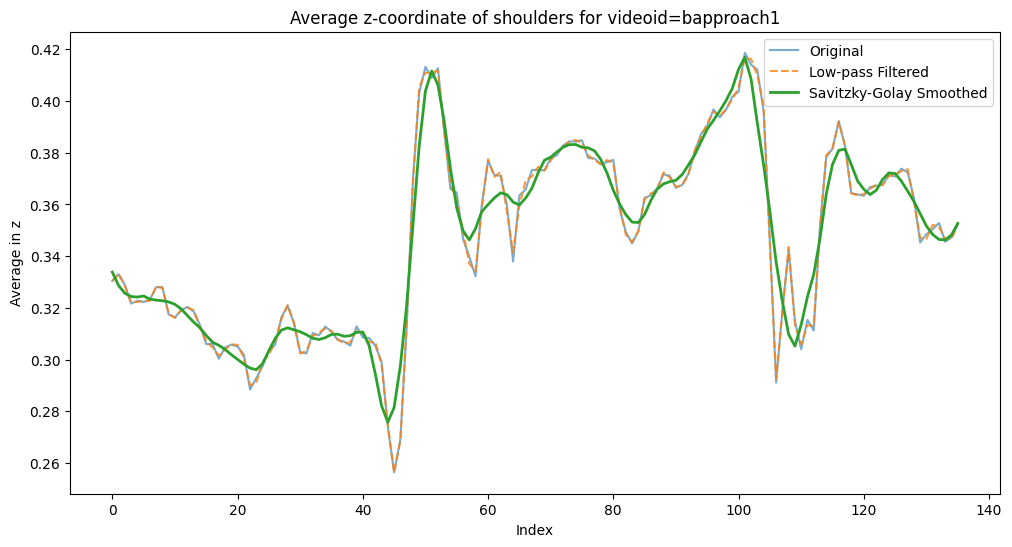

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, savgol_filter

# Definir el video_id que deseas graficar
specific_video_id = "bapproach1"  # Cambia este valor al videoid que quieras analizar

# Filtrar los datos por el video_id
filtered_data = movement_data[movement_data['videoid'] == specific_video_id]

# Calcular el promedio de las coordenadas z de los hombros
filtered_data['SHOULDERS_AVERAGE_z'] = (
    filtered_data['LEFT_SHOULDER_z'] + filtered_data['RIGHT_SHOULDER_z']
) / 2

# Configuración del filtro pasa bajas (Butterworth)
fs = 30  # Frecuencia de muestreo en Hz (ajústalo según tus datos)
cutoff = 12  # Frecuencia de corte del filtro pasa bajas en Hz
nyquist = 0.5 * fs
normal_cutoff = cutoff / nyquist

# Crear el filtro Butterworth
b, a = butter(4, normal_cutoff, btype='low', analog=False)

# Aplicar el filtro pasa bajas
average_filtered = filtfilt(b, a, filtered_data['SHOULDERS_AVERAGE_z'])

# Aplicar el filtro Savitzky-Golay
average_smoothed = savgol_filter(average_filtered, window_length=11, polyorder=3)

# Graficar los datos originales, filtrados y suavizados
plt.figure(figsize=(12, 6))
plt.plot(
    filtered_data['SHOULDERS_AVERAGE_z'].reset_index(drop=True), label='Original', alpha=0.6
)
plt.plot(average_filtered, label='Low-pass Filtered', linestyle='--', alpha=0.8)
plt.plot(average_smoothed, label='Savitzky-Golay Smoothed', linestyle='-', linewidth=2)
plt.xlabel('Index')
plt.ylabel('Average in z')
plt.title(f'Average z-coordinate of shoulders for videoid={specific_video_id}')
plt.legend()
plt.show()


C:\Users\57312\AppData\Local\Temp\ipykernel_11512\2882093925.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['KNEE_SHOULDER_DISTANCE_y'] = abs(


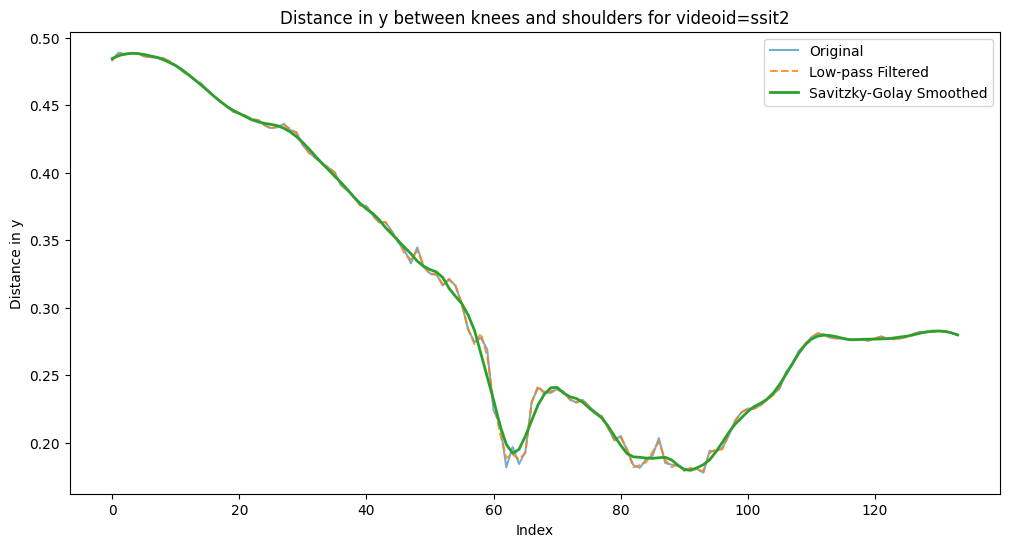

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, savgol_filter

# Definir el video_id que deseas graficar
specific_video_id = "ssit2"  # Cambia este valor al videoid que quieras analizar

# Filtrar los datos por el video_id
filtered_data = movement_data[movement_data['videoid'] == specific_video_id]

# Calcular la distancia en y entre las rodillas y los hombros
filtered_data['KNEE_SHOULDER_DISTANCE_y'] = abs(
    (filtered_data['LEFT_KNEE_y'] + filtered_data['RIGHT_KNEE_y']) / 2 - 
    (filtered_data['LEFT_SHOULDER_y'] + filtered_data['RIGHT_SHOULDER_y']) / 2
)

# Configuración del filtro pasa bajas (Butterworth)
fs = 30  # Frecuencia de muestreo en Hz (ajústalo según tus datos)
cutoff = 12  # Frecuencia de corte del filtro pasa bajas en Hz
nyquist = 0.5 * fs
normal_cutoff = cutoff / nyquist

# Crear el filtro Butterworth
b, a = butter(4, normal_cutoff, btype='low', analog=False)

# Aplicar el filtro pasa bajas
distance_filtered = filtfilt(b, a, filtered_data['KNEE_SHOULDER_DISTANCE_y'])

# Aplicar el filtro Savitzky-Golay
distance_smoothed = savgol_filter(distance_filtered, window_length=11, polyorder=3)

# Graficar los datos originales, filtrados y suavizados
plt.figure(figsize=(12, 6))
plt.plot(filtered_data['KNEE_SHOULDER_DISTANCE_y'].reset_index(drop=True), label='Original', alpha=0.6)
plt.plot(distance_filtered, label='Low-pass Filtered', linestyle='--', alpha=0.8)
plt.plot(distance_smoothed, label='Savitzky-Golay Smoothed', linestyle='-', linewidth=2)
plt.xlabel('Index')
plt.ylabel('Distance in y')
plt.title(f'Distance in y between knees and shoulders for videoid={specific_video_id}')
plt.legend()
plt.show()
